In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from keras.datasets import mnist

torch.manual_seed(0)

In [2]:
# Download MNIST Data
(mnist_train, labels_train), (mnist_test, labels_test) = mnist.load_data()

# Load data as Numpy arrays of size (#datapoints, 28*28=784)
mnist_train = mnist_train.astype('float32') / 255.
mnist_test = mnist_test.astype('float32') / 255.
mnist_train = mnist_train.reshape((len(mnist_train), np.prod(mnist_train.shape[1:])))
mnist_test = mnist_test.reshape((len(mnist_test), np.prod(mnist_test.shape[1:])))

# Split test data into a test and validation set:
val_data = mnist_test[:(mnist_test.shape[0]//2),:]
test_data = mnist_test[(mnist_test.shape[0]//2):,:]
train_data = mnist_train

val_labels = labels_test[:(mnist_test.shape[0]//2)]
test_labels = labels_test[(mnist_test.shape[0]//2):]
train_labels = labels_train

# Display dataset information
print("Downloaded the following data:")
print(f"train_data has shape {train_data.shape}, containing {train_data.shape[0]} images represented as ({train_data.shape[1]}, 1) vectors")
print(f"val_data has shape {val_data.shape}, containing {val_data.shape[0]} images represented as ({val_data.shape[1]}, 1) vectors")
print(f"train_data has shape {test_data.shape}, containing {test_data.shape[0]} images represented as ({test_data.shape[1]}, 1) vectors")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Downloaded the following data:
train_data has shape (60000, 784), containing 60000 images represented as (784, 1) vectors
val_data has shape (5000, 784), containing 5000 images represented as (784, 1) vectors
train_data has shape (5000, 784), containing 5000 images represented as (784, 1) vectors


In [3]:
# Create a Dataset class to use with PyTorch's Built-In Dataloaders
class MNISTDataset(Dataset):
    '''
    A custom dataset class to use with PyTorch's built-in dataloaders.
    This will make feeding images to our models much easier downstream.

    data: np.arrays downloaded from Keras' databases
    vectorize: if True, outputed image data will be (784,)
                   if False, outputed image data will be (28,28)
    '''
    def __init__(self, data, labels, vectorize=True):
        self.data = data
        self.labels = labels
        self.vectorize = vectorize

    def __getitem__(self, idx):
        image_data = self.data[idx, :]
        image_data = image_data.reshape((1,28,28))
        if self.vectorize:
            image_data = image_data.reshape((784,))
        image_label = self.labels[idx]
        return image_data, image_label

    def __len__(self):
        return self.data.shape[0]

# Create MNISTDataset objects for each of our train/val/test sets
train_dataset = MNISTDataset(train_data, train_labels)
val_dataset = MNISTDataset(val_data, val_labels)
test_dataset = MNISTDataset(test_data, test_labels)

# Create a PyTorch dataloader for each train/val/test set
train_loader = DataLoader(train_dataset, batch_size=256)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# Display dataloader info
print("Created the following Dataloaders:")
print(f"train_loader has {len(train_loader)} batches of training data")
print(f"val_loader has {len(val_loader)} batches of validation data")
print(f"test_loader has {len(test_loader)} batches of testing data")

Created the following Dataloaders:
train_loader has 235 batches of training data
val_loader has 20 batches of validation data
test_loader has 20 batches of testing data


In [34]:
def get_modules(module_object):
    '''
    gets a list of modules without nn.Sequential groupings, as a list of strings
    '''
    modules_list = []
    for module in module_object.children():
        if isinstance(module, nn.Sequential):
            modules_list += get_modules(module)
        else:
            modules_list.append(str(module))
    return modules_list

## A Simple (One-Layer) Autoencoder

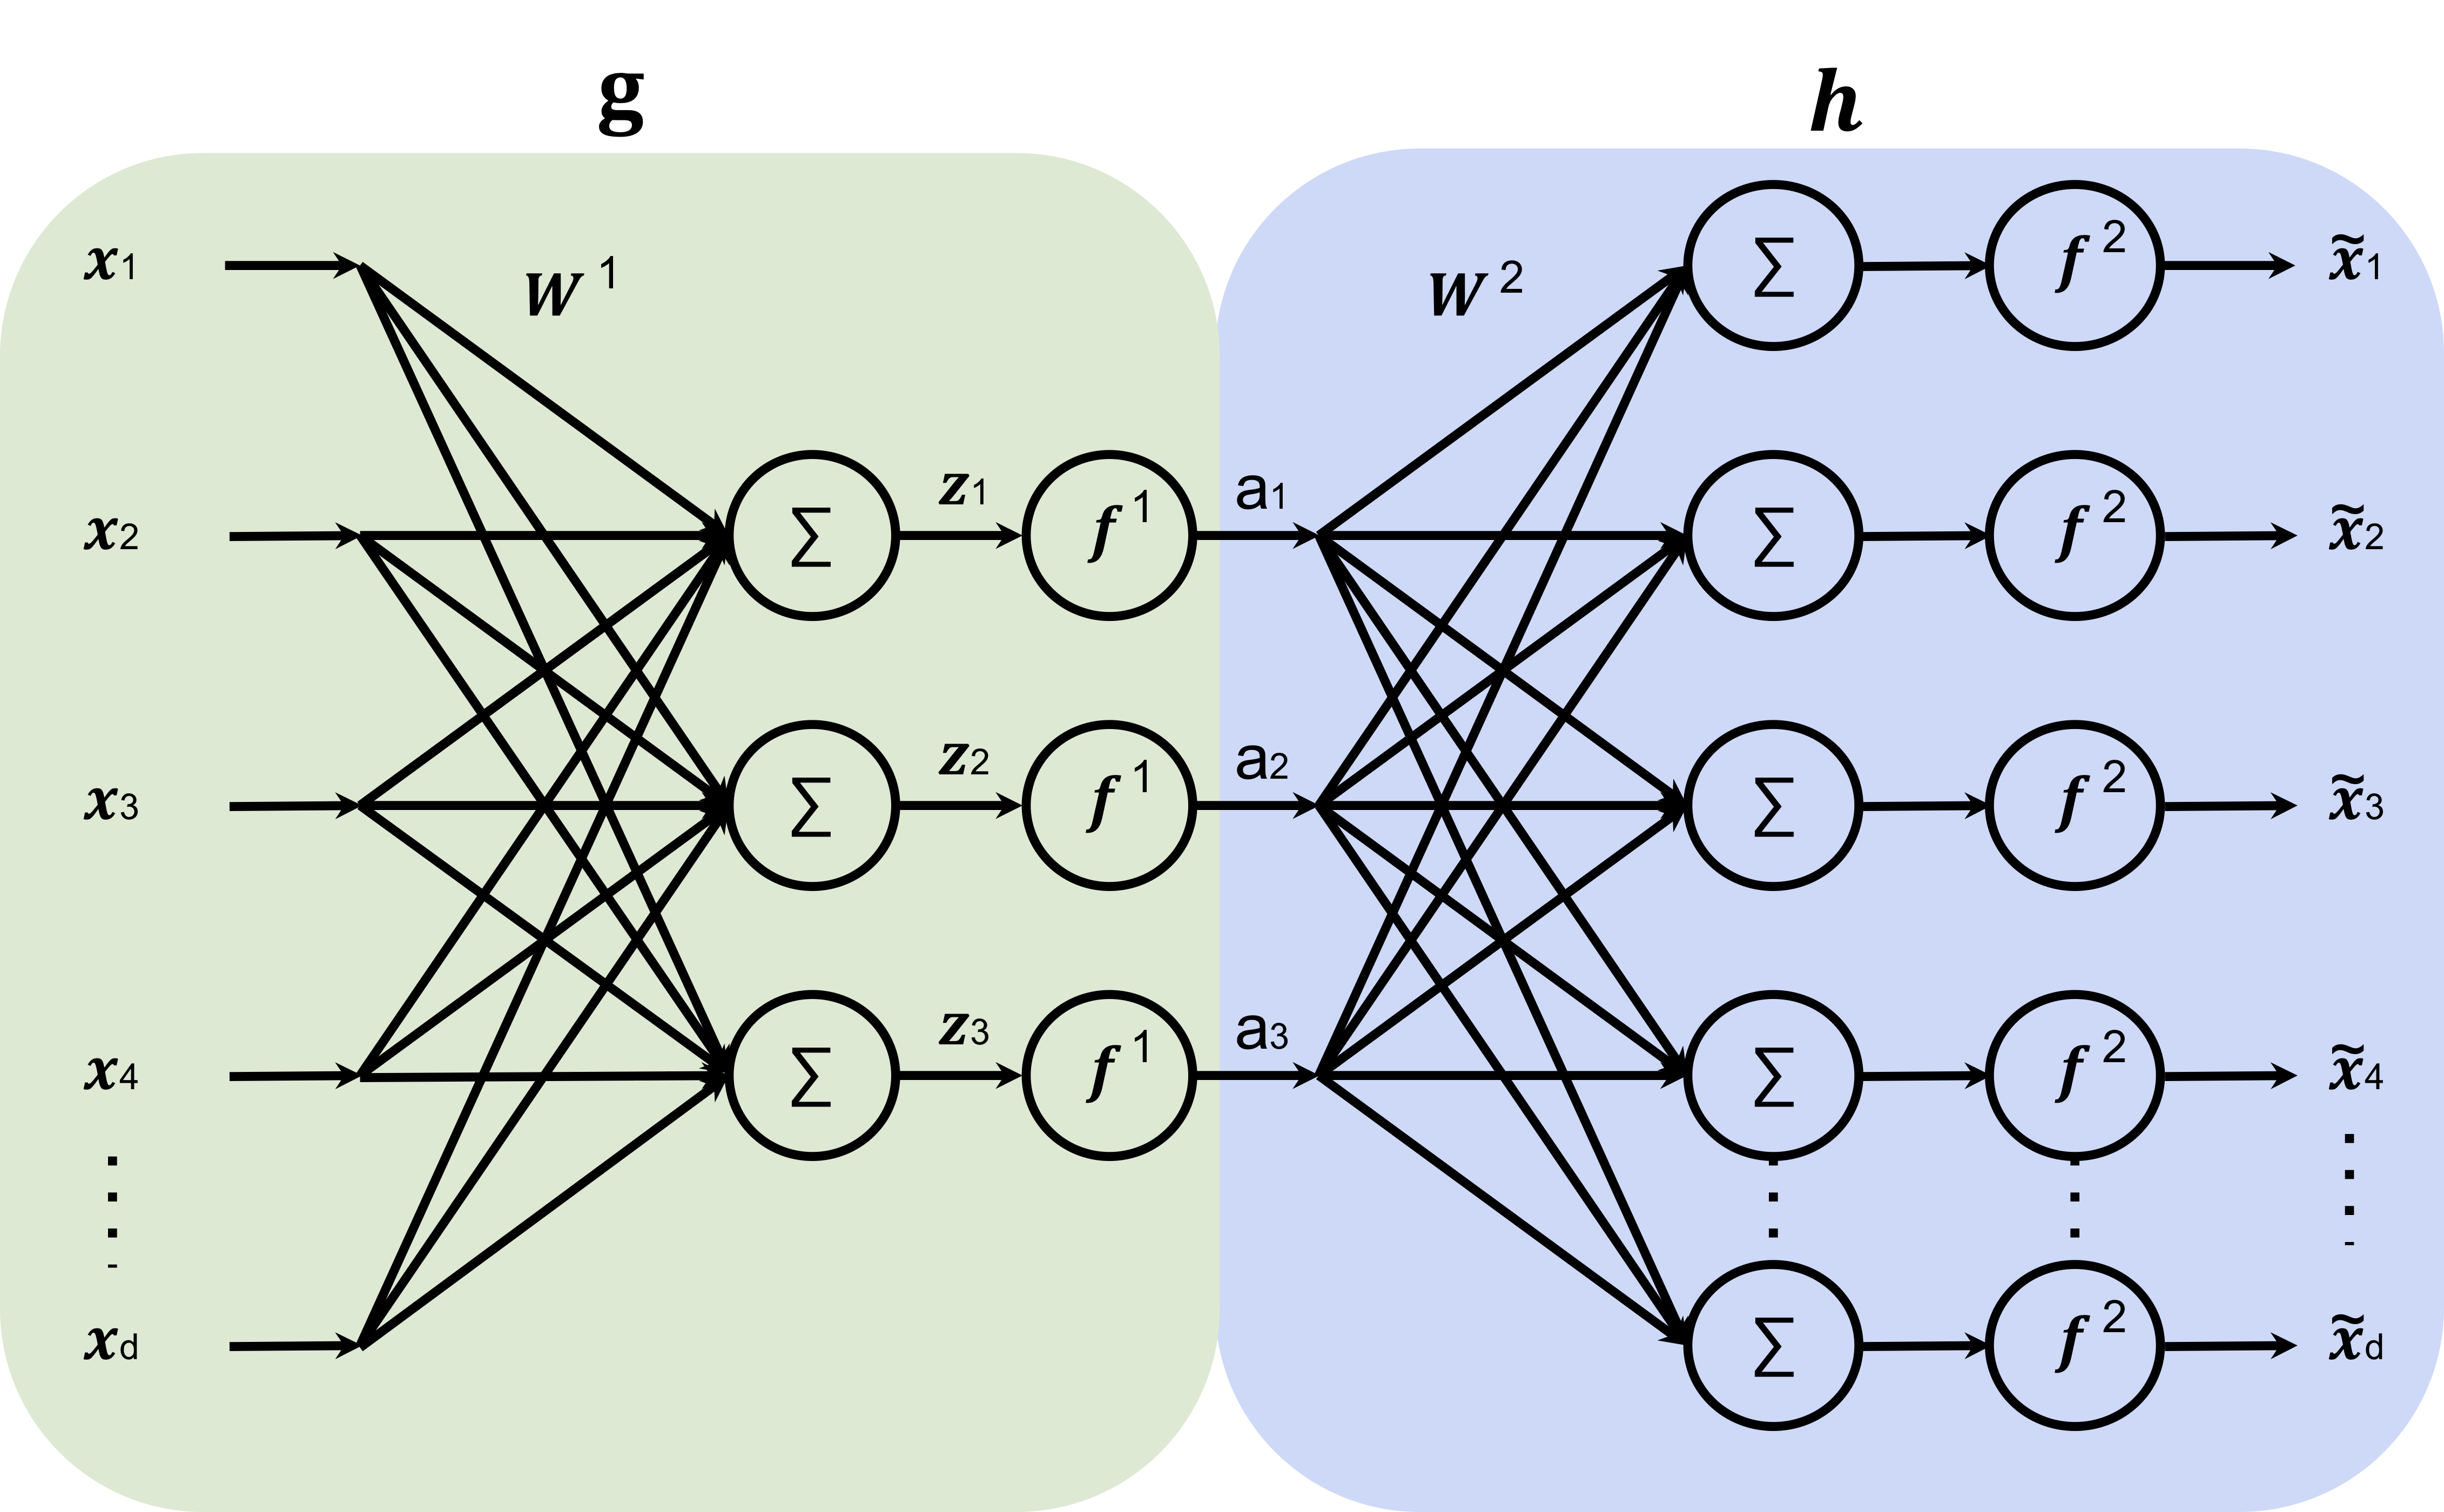


### Architecture Implementation


In [6]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, representation_size):

        super(SimpleAutoEncoder, self).__init__()
        self.representation_size = representation_size

        self.encoder_preactivation = nn.Linear(784, representation_size)
        self.encoder_activation = nn.ReLU()
        self.decoder_preactivation = nn.Linear(representation_size, 784)

    def encode(self, x):
        return self.encoder_activation( self.encoder_preactivation(x) )

    def decode(self, z):
        return self.decoder_preactivation(z)

    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime

In [8]:
print(get_modules(SimpleAutoEncoder(32)))

['Linear(in_features=784, out_features=32, bias=True)', 'ReLU()', 'Linear(in_features=32, out_features=784, bias=True)']


In [9]:
def train(model, device, train_loader, optimizer, val_loader=None):
    model.train()

    # The average square difference in pixel values between the input and the output
    total_loss = 0

    for batch_idx, (input, _) in enumerate(train_loader):
        input = input.to(device)

        # Zero out gradients from previous iteration
        optimizer.zero_grad()

        output = model.forward(input)

        loss_function = nn.MSELoss()
        loss_value = loss_function(output, input)

        # Perform backprop
        loss_value.backward()
        optimizer.step()
        total_loss += loss_value

    return total_loss.item()/len(train_loader)

In [10]:
def test(model, device, test_loader):
    model.eval()

    # The average square difference in pixel values between the input and the output
    test_loss = 0

    with torch.no_grad():
        for input, _ in test_loader:

            # send input image to GPU if using GPU
            input = input.to(device)

            # run input through our model
            output = model(input)

            loss_function = nn.MSELoss(reduction = 'mean')
            test_loss += loss_function(output, input)

    # calculate average loss per batch
    test_loss /= len(test_loader)
    return test_loss.item()

In [32]:
representation_size = 32

epochs = 50

# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

simple_autoencoder = SimpleAutoEncoder(representation_size).to(device)
optimizer = torch.optim.Adam(simple_autoencoder.parameters())

for epoch in range(1, epochs+1):
    train_loss = train(simple_autoencoder, device, train_loader, optimizer)
    val_loss = test(simple_autoencoder, device, val_loader)
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

print('Test Loss:', test(simple_autoencoder, device, test_loader))

Train Epoch: 01 	Training Loss: 0.067175 	Validation Loss: 0.049856
Train Epoch: 02 	Training Loss: 0.044020 	Validation Loss: 0.037738
Train Epoch: 03 	Training Loss: 0.035127 	Validation Loss: 0.032968
Train Epoch: 04 	Training Loss: 0.032421 	Validation Loss: 0.031498
Train Epoch: 05 	Training Loss: 0.030520 	Validation Loss: 0.029921
Train Epoch: 06 	Training Loss: 0.029924 	Validation Loss: 0.029661
Train Epoch: 07 	Training Loss: 0.029731 	Validation Loss: 0.029556
Train Epoch: 08 	Training Loss: 0.029637 	Validation Loss: 0.029507
Train Epoch: 09 	Training Loss: 0.029585 	Validation Loss: 0.029485
Train Epoch: 10 	Training Loss: 0.029559 	Validation Loss: 0.029472
Train Epoch: 11 	Training Loss: 0.029536 	Validation Loss: 0.029464
Train Epoch: 12 	Training Loss: 0.029524 	Validation Loss: 0.029461
Train Epoch: 13 	Training Loss: 0.029518 	Validation Loss: 0.029456
Train Epoch: 14 	Training Loss: 0.029512 	Validation Loss: 0.029453
Train Epoch: 15 	Training Loss: 0.029314 	Valida

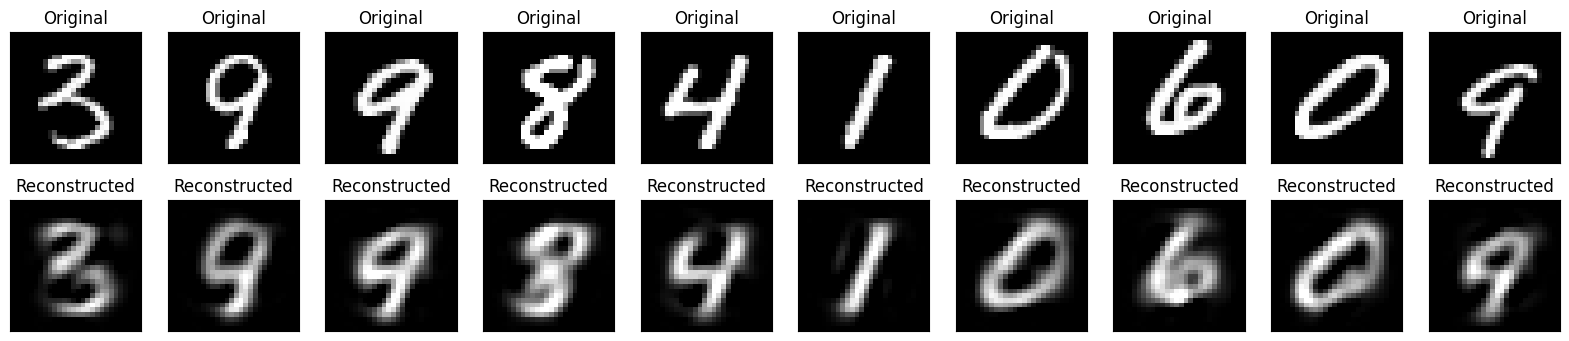

In [39]:
x_test = torch.tensor(test_dataset.data).to(device)
encoded_imgs = simple_autoencoder.encode(x_test.float())
decoded_imgs = simple_autoencoder.decode(encoded_imgs).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Original')
    plt.imshow(x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    plt.imshow(np.clip( decoded_imgs[i].reshape(28, 28), 0., 1.) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## A Deep (Multi-Layer) Autoencoder


In [13]:
class DeepAutoEncoder(nn.Module):
    '''
    An autoencoder with two fully-connected layer for the encoder, and two
    fully-connected layer for the decoder.

    compress: number of units in hidden layer of encoder and decoder

    representation_size: integer reprsenting the size of the learned representation.

    input_size: integer representing the size of each input column vector.
    '''
    def __init__(self, compress, representation_size, input_size=784):
        super(DeepAutoEncoder, self).__init__()
        self.representation_size = representation_size
        self.compress = compress
        self.input_size = input_size

        ## First layer of encoder
        self.encoder_preactivation_1 = nn.Linear(input_size, compress)
        self.encoder_activation_1 = nn.ReLU()
        ## Second layer of encoder
        self.encoder_preactivation_2 = nn.Linear(compress, representation_size)
        self.encoder_activation_2 = nn.ReLU()
        ## First layer of decoder
        self.decoder_preactivation_1 = nn.Linear(representation_size, compress)
        self.decoder_activation_1 = nn.ReLU()
        ## Second layer of decoder
        self.decoder_preactivation_2 = nn.Linear(compress, input_size)

    def encode(self, x):
        a1 = self.encoder_preactivation_1(x)
        z1 = self.encoder_activation_1(a1)
        a2 = self.encoder_preactivation_2(z1)
        return self.encoder_activation_2(a2)

    def decode(self, a):
        a1 = self.decoder_preactivation_1(a)
        z1 = self.decoder_activation_1(a1)
        return self.decoder_preactivation_2(z1)

    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime

In [14]:
print(get_modules(DeepAutoEncoder(200, 32)))

['Linear(in_features=784, out_features=200, bias=True)', 'ReLU()', 'Linear(in_features=200, out_features=32, bias=True)', 'ReLU()', 'Linear(in_features=32, out_features=200, bias=True)', 'ReLU()', 'Linear(in_features=200, out_features=784, bias=True)']


In [35]:
compress = 200
representation_size = 32
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

deep_autoencoder = DeepAutoEncoder(compress, representation_size).to(device)
optimizer = torch.optim.Adam(deep_autoencoder.parameters())

for epoch in range(1, epochs+1):
    train_loss = train(deep_autoencoder, device, train_loader, optimizer)
    val_loss = test(deep_autoencoder, device, val_loader)
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

print('Test Loss:', test(deep_autoencoder, device, test_loader))

Train Epoch: 01 	Training Loss: 0.039798 	Validation Loss: 0.025715
Train Epoch: 02 	Training Loss: 0.024135 	Validation Loss: 0.023199
Train Epoch: 03 	Training Loss: 0.022272 	Validation Loss: 0.021699
Train Epoch: 04 	Training Loss: 0.020984 	Validation Loss: 0.020636
Train Epoch: 05 	Training Loss: 0.020043 	Validation Loss: 0.019830
Train Epoch: 06 	Training Loss: 0.019349 	Validation Loss: 0.019277
Train Epoch: 07 	Training Loss: 0.018802 	Validation Loss: 0.018754
Train Epoch: 08 	Training Loss: 0.018342 	Validation Loss: 0.018329
Train Epoch: 09 	Training Loss: 0.017944 	Validation Loss: 0.017986
Train Epoch: 10 	Training Loss: 0.017593 	Validation Loss: 0.017716
Train Epoch: 11 	Training Loss: 0.017300 	Validation Loss: 0.017462
Train Epoch: 12 	Training Loss: 0.017041 	Validation Loss: 0.017220
Train Epoch: 13 	Training Loss: 0.016816 	Validation Loss: 0.016949
Train Epoch: 14 	Training Loss: 0.016604 	Validation Loss: 0.016703
Train Epoch: 15 	Training Loss: 0.016413 	Valida

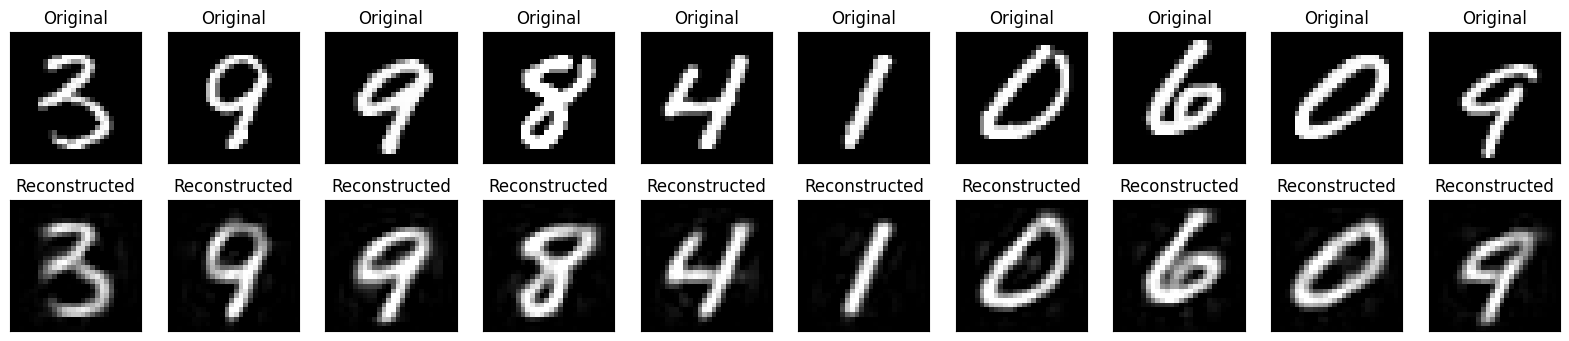

In [38]:
x_test = torch.tensor(test_dataset.data).to(device)
encoded_imgs = deep_autoencoder.encode(x_test.float())
decoded_imgs = deep_autoencoder.decode(encoded_imgs).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Original')
    plt.imshow(x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    plt.imshow(np.clip( decoded_imgs[i].reshape(28, 28), 0., 1.) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Parameter Analysis for Autoencoders

To compare the computational cost between the **SimpleAutoEncoder** and the **DeepAutoEncoder**, let's calculate the total number of parameters (weights and biases) for each model.

### SimpleAutoEncoder

1. **Encoder Layer**:
   - **Input size** = 784, **Output size** = 32 (representation size).
   - **Parameters (weights)**: \( 784 \times 32 = 25,088 \)
   - **Biases**: 32
   - **Total for encoder layer** = \( 25,088 + 32 = 25,120 \)

2. **Decoder Layer**:
   - **Input size** = 32, **Output size** = 784.
   - **Parameters (weights)**: \( 32 \times 784 = 25,088 \)
   - **Biases**: 784
   - **Total for decoder layer** = \( 25,088 + 784 = 25,872 \)

**Total Parameters for SimpleAutoEncoder**:
\[
25,120 + 25,872 = 50,992
\]

### DeepAutoEncoder

1. **First Encoder Layer**:
   - **Input size** = 784, **Output size** = 200.
   - **Parameters (weights)**: \( 784 \times 200 = 156,800 \)
   - **Biases**: 200
   - **Total for first encoder layer** = \( 156,800 + 200 = 157,000 \)

2. **Second Encoder Layer**:
   - **Input size** = 200, **Output size** = 32.
   - **Parameters (weights)**: \( 200 \times 32 = 6,400 \)
   - **Biases**: 32
   - **Total for second encoder layer** = \( 6,400 + 32 = 6,432 \)

3. **First Decoder Layer**:
   - **Input size** = 32, **Output size** = 200.
   - **Parameters (weights)**: \( 32 \times 200 = 6,400 \)
   - **Biases**: 200
   - **Total for first decoder layer** = \( 6,400 + 200 = 6,600 \)

4. **Second Decoder Layer**:
   - **Input size** = 200, **Output size** = 784.
   - **Parameters (weights)**: \( 200 \times 784 = 156,800 \)
   - **Biases**: 784
   - **Total for second decoder layer** = \( 156,800 + 784 = 157,584 \)

**Total Parameters for DeepAutoEncoder**:
\[
157,000 + 6,432 + 6,600 + 157,584 = 327,616
\]

### Summary

- **SimpleAutoEncoder**: 50,992 parameters
- **DeepAutoEncoder**: 327,616 parameters

The DeepAutoEncoder has significantly more parameters, which contributes to its greater expressive capacity but also increases computational cost and memory requirements.


## Denoising Images with Your AutoEncoders


In [24]:
def train_denoiser(model, device, train_loader, optimizer):
    model.train()

    total_loss = 0

    # We'll iterate through each batch. One call of train() trains for 1 epoch.
    # batch_idx: an integer representing which batch number we're on
    # noisy: a pytorch tensor representing the noisy image to input
    # clean: a pytorch tensor representing the noise-less version of our input
    for batch_idx, (noisy, clean) in enumerate(train_loader):
        noisy = noisy.to(device, dtype=torch.float)
        clean = clean.to(device, dtype=torch.float)

        # Zero out gradients from previous iteration
        optimizer.zero_grad()

        output = model.forward(noisy)
        loss_function = nn.MSELoss()
        loss_value = loss_function(output, clean)

        # Perform backprop
        loss_value.backward()
        optimizer.step()
        total_loss += loss_value

    return total_loss.item()/len(train_loader)

In [25]:
def test_denoiser(model, device, test_loader):
    model.eval()

    test_loss = 0

    # don’t track gradients in testing, since no backprop
    with torch.no_grad():

        # iterate thorugh each test image
        # noisy: a pytorch tensor representing the noisy image to input
        # clean: a pytorch tensor representing the noise-less version of our input
        for noisy, clean in test_loader:

            noisy = noisy.to(device, dtype=torch.float)
            clean = clean.to(device, dtype=torch.float)

            output = model(noisy)
            loss_function = nn.MSELoss()
            test_loss += loss_function(output, clean)

    test_loss /= len(test_loader)
    return test_loss

In [26]:
# Construct a dataset and dataloader of images with white noise overlaid
class NoisyMNISTDataset(Dataset):
    '''
    A custom dataset class to use with PyTorch's built-in dataloaders.
    This will make feeding images to our models much easier downstream.

    data: np.arrays downloaded from Keras' databases
    vectorize: if True, outputed image data will be (784,)
                   if False, outputed image data will be (28,28)
    '''
    def __init__(self, data, noise_factor=0.3, vectorize=False):
        self.noisy_data = np.clip(data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape), 0., 1.)
        self.clean_data = data
        self.vectorize = vectorize
        self.noise_factor = noise_factor

    def __getitem__(self, idx):
        clean_image_data = self.clean_data[idx, :].reshape((1,28,28))
        noisy_image_data = self.noisy_data[idx, :].reshape((1,28,28))
        if self.vectorize:
            clean_image_data = clean_image_data.reshape((784,))
            noisy_image_data = noisy_image_data.reshape((784,))
        return noisy_image_data, clean_image_data

    def __len__(self):
        return self.clean_data.shape[0]

noise_factor = 0.3
noisy_train_dataset = NoisyMNISTDataset(train_data, noise_factor=noise_factor, vectorize=True)
noisy_val_dataset = NoisyMNISTDataset(val_data, noise_factor=noise_factor, vectorize=True)
noisy_test_dataset = NoisyMNISTDataset(test_data, noise_factor=noise_factor, vectorize=True)

noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=256)
noisy_val_loader = DataLoader(noisy_val_dataset, batch_size=256)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=256)

## Denoising with the SimpleAutoEncoder

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_autoencoder = SimpleAutoEncoder(32).to(device)

optimizer = torch.optim.Adam(denoising_autoencoder.parameters())
epochs = 50

for epoch in range(1, epochs+1):
    train_loss = train_denoiser(denoising_autoencoder, device, noisy_train_loader, optimizer)
    val_loss = test_denoiser(denoising_autoencoder, device, noisy_val_loader, )
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

print('Test Loss:', test_denoiser(denoising_autoencoder, device, noisy_test_loader))

Train Epoch: 01 	Training Loss: 0.074359 	Validation Loss: 0.059686
Train Epoch: 02 	Training Loss: 0.057715 	Validation Loss: 0.052521
Train Epoch: 03 	Training Loss: 0.052234 	Validation Loss: 0.049024
Train Epoch: 04 	Training Loss: 0.049919 	Validation Loss: 0.048075
Train Epoch: 05 	Training Loss: 0.049384 	Validation Loss: 0.047839
Train Epoch: 06 	Training Loss: 0.049176 	Validation Loss: 0.047718
Train Epoch: 07 	Training Loss: 0.049051 	Validation Loss: 0.047632
Train Epoch: 08 	Training Loss: 0.048968 	Validation Loss: 0.047570
Train Epoch: 09 	Training Loss: 0.048911 	Validation Loss: 0.047524
Train Epoch: 10 	Training Loss: 0.048869 	Validation Loss: 0.047491
Train Epoch: 11 	Training Loss: 0.048838 	Validation Loss: 0.047468
Train Epoch: 12 	Training Loss: 0.048814 	Validation Loss: 0.047451
Train Epoch: 13 	Training Loss: 0.048794 	Validation Loss: 0.047439
Train Epoch: 14 	Training Loss: 0.048778 	Validation Loss: 0.047429
Train Epoch: 15 	Training Loss: 0.048764 	Valida

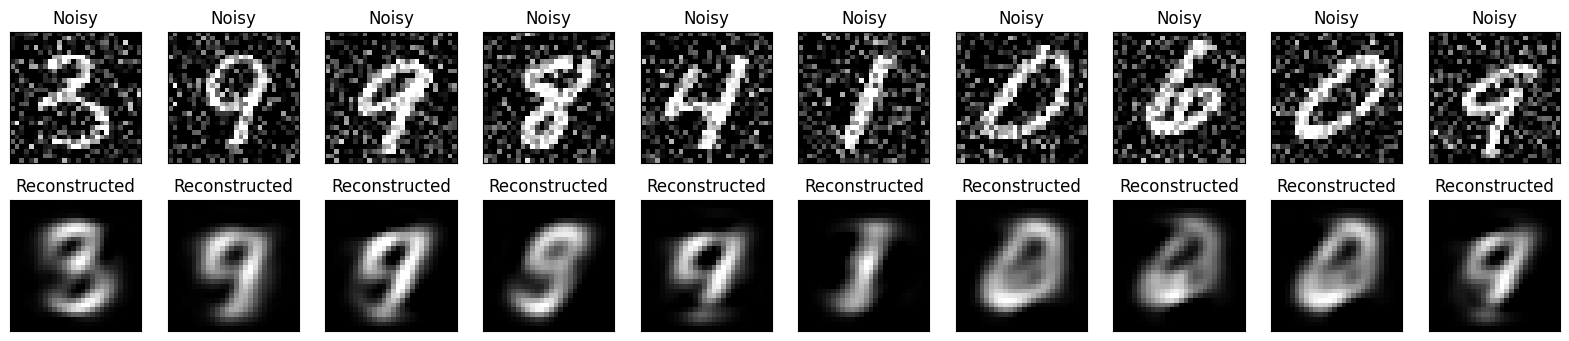

In [37]:
noisy_x_test = torch.tensor(noisy_test_dataset.noisy_data).to(device)
encoded_imgs4 = denoising_autoencoder.encode(noisy_x_test.float())
decoded_imgs4 = denoising_autoencoder.decode(encoded_imgs4).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Noisy')
    plt.imshow(noisy_x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    clipped = np.clip( decoded_imgs4[i].reshape(28, 28), 0., 1.)
    plt.imshow(clipped)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising with the DeepAutoEncoder

In [31]:
compress = 200

# Set representation size
representation_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_autoencoder = DeepAutoEncoder(compress, representation_size).to(device)

optimizer = torch.optim.Adam(denoising_autoencoder.parameters())
epochs = 50

for epoch in range(1, epochs+1):
    train_loss = train_denoiser(denoising_autoencoder, device, noisy_train_loader, optimizer)
    val_loss = test_denoiser(denoising_autoencoder, device, noisy_val_loader, )
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

print('Test Loss:', test_denoiser(denoising_autoencoder, device, noisy_test_loader))

Train Epoch: 01 	Training Loss: 0.046419 	Validation Loss: 0.032121
Train Epoch: 02 	Training Loss: 0.029717 	Validation Loss: 0.028454
Train Epoch: 03 	Training Loss: 0.027450 	Validation Loss: 0.027075
Train Epoch: 04 	Training Loss: 0.026244 	Validation Loss: 0.026079
Train Epoch: 05 	Training Loss: 0.025361 	Validation Loss: 0.025309
Train Epoch: 06 	Training Loss: 0.024671 	Validation Loss: 0.024717
Train Epoch: 07 	Training Loss: 0.024125 	Validation Loss: 0.024258
Train Epoch: 08 	Training Loss: 0.023689 	Validation Loss: 0.023892
Train Epoch: 09 	Training Loss: 0.023330 	Validation Loss: 0.023592
Train Epoch: 10 	Training Loss: 0.023023 	Validation Loss: 0.023337
Train Epoch: 11 	Training Loss: 0.022751 	Validation Loss: 0.023091
Train Epoch: 12 	Training Loss: 0.022506 	Validation Loss: 0.022843
Train Epoch: 13 	Training Loss: 0.022283 	Validation Loss: 0.022626
Train Epoch: 14 	Training Loss: 0.022080 	Validation Loss: 0.022414
Train Epoch: 15 	Training Loss: 0.021897 	Valida

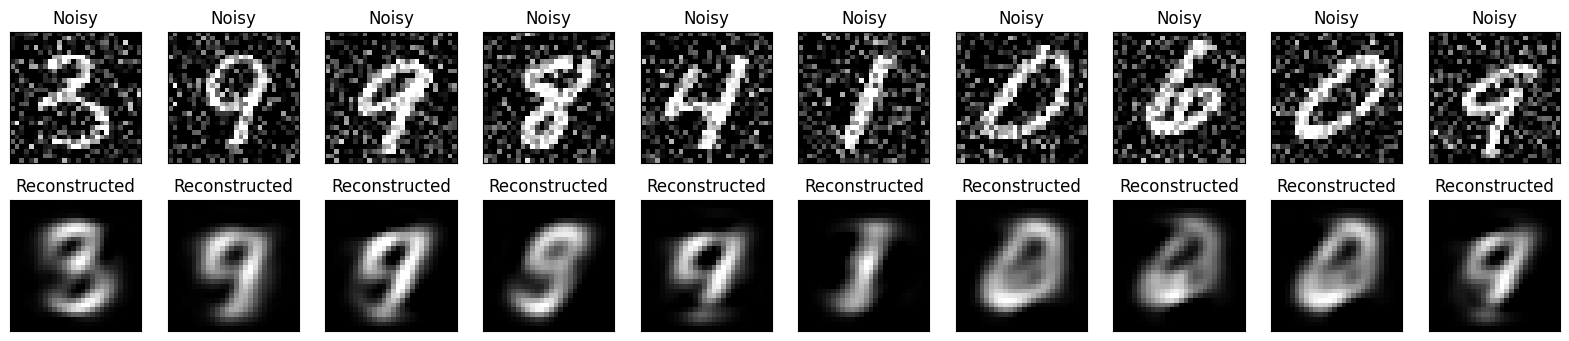

In [36]:
noisy_x_test = torch.tensor(noisy_test_dataset.noisy_data).to(device)
encoded_imgs4 = denoising_autoencoder.encode(noisy_x_test.float())
decoded_imgs4 = denoising_autoencoder.decode(encoded_imgs4).cpu().detach().numpy()

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Noisy')
    plt.imshow(noisy_x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    clipped = np.clip( decoded_imgs4[i].reshape(28, 28), 0., 1.)
    plt.imshow(clipped)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()